# Overfitting a Transformer Autoencoder 

## Framing

> GOAL: Use a bunch of transformer encoder blocks to compress a small set of spacetime patches from a video into a small latent dimension bottleneck. Reconstruct the original patches from the latent dimension using some transformer decoder blocks. 

__Encoders__: The first 1-2 encoder blocks are unique. The remaining are the same (cf. Perceiver). 
 - {MHA -> FFN} + residual + layer norm. 
 - Question: How to get bottleneck on the first "cold start"? 
	 - Assumption: We start with the latent dimension initialized to zeros.
 - `latent -> latent`: Encoder only. 
 - `datum -> latent`: Query = latent; key/value = data. Residual connection with layernorm as before -> adds to the latent, doesn't overwrite. 

__Decoders__: We want to be able to map from `latent` -> `reconstruction`. 
 - We can query the latent state with the positional encodings of the desired patch positions!
 - Pretty much the same as the encoder 

## 0: Setup & Data Acquisition

In [1]:
## Import Box 
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math

import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
from tqdm import tqdm
import cv2
# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

2022-10-06 13:32:07.612308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 13:32:07.870879: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-06 13:32:07.939440: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-06 13:32:08.623525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
## Utility imports  
sys.path.append("../src")
import video_loader as vl
import video_preprocess as vp 

In [3]:
## Meta/constants 
DATA_FOLDER = "../datasets/downloads"
num_videos, num_frames = 16, 11
output_size = (240, 360)

patch_height = 16
patch_width = 16
patch_duration = 3

batch_size=1

# Fourier feature codes 
k_space = 15
mu_space = 20 
k_time = 64 
mu_time = 200

In [4]:
print("Getting VideoSet...")
VideoSet = vl.get_videoset("../datasets/downloads", num_videos, num_frames, output_size=output_size)

print("Making patches from Videoset...")
PatchSet = vp.make_patchset(VideoSet, patch_duration, patch_height, patch_width)

print("Making the flat patch set...")
FlatPatchSet = vp.patch_to_flatpatch(PatchSet, batch_size=batch_size)

print("Adding codes to the PatchSet...")
CodedPatchedSet = PatchSet.map(lambda x: vp.add_spacetime_codes(x, 
		k_space=k_space, mu_space=mu_space, k_time=k_time, mu_time=mu_time))

print("Flattening the coded + patched dataset...")
FlatCodedPatchedSet = vp.patch_to_flatpatch(CodedPatchedSet, batch_size=batch_size)

Getting VideoSet...


  0%|          | 0/16 [00:00<?, ?it/s]2022-10-06 13:32:15.037813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 13:32:16.032786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12478 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-10-06 13:32:16.033620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20666 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:68:00.0, compute capability: 8.6
100%|██████████| 16/16 [00:02<00:00,  6.35it/s]


Making patches from Videoset...
Making the flat patch set...
Flattening a tensor of shape:  (None, 3, 15, 22, 2304)
Adding codes to the PatchSet...
Flattening the coded + patched dataset...
Flattening a tensor of shape:  (1, 3, 15, 22, 2495)


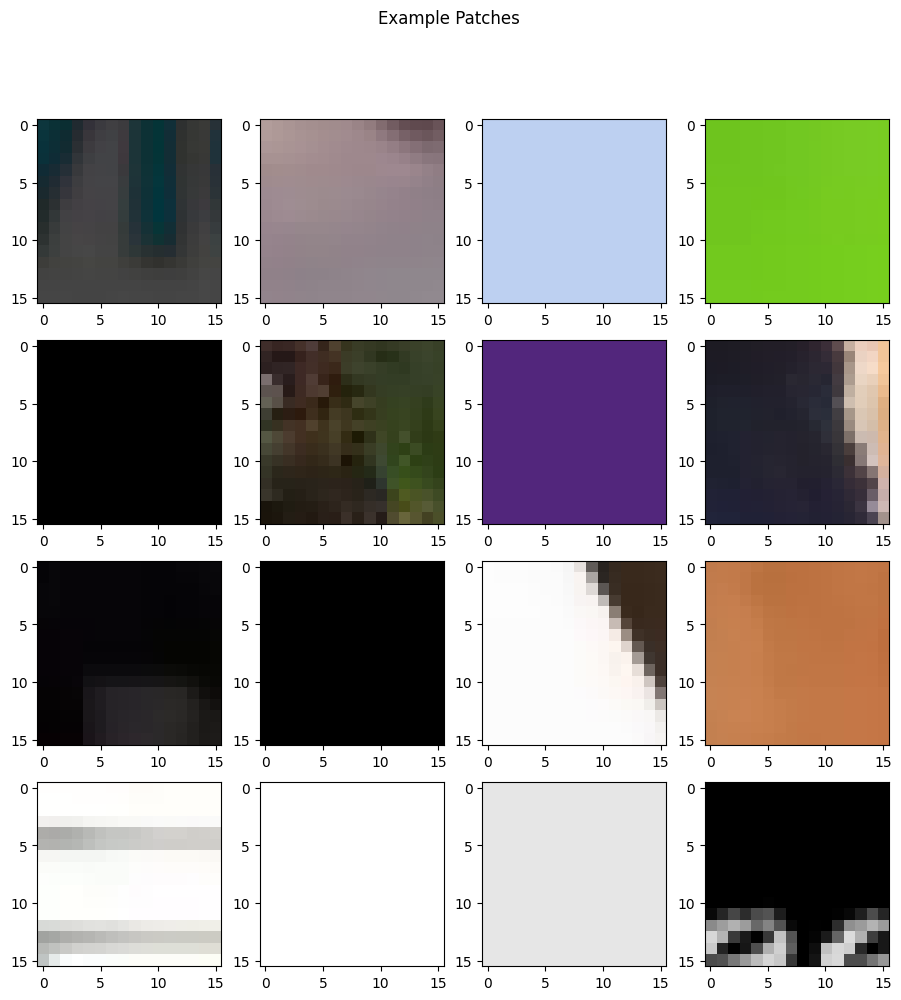

In [7]:
## Let's decode a single spacetime patch

nplots = math.ceil(math.sqrt(len(PatchSet)))
fig, axs = plt.subplots(nplots, nplots)
fig.set_figheight(11)
fig.set_figwidth(11)

cnt=0
for element in PatchSet: 
	# plt.imshow()tf.reshape(element[0,0,:,:,0]), (16,16,3)
	# print("Element shape: ", element.shape)
	first_patch = element[0,2,3,4,:]
	# print("First patch shape: ", first_patch.shape)
	first_patch = tf.reshape(first_patch, [patch_duration, patch_height, patch_width, 3] ) # time, height, width, channels 
	axs[cnt//nplots, cnt%nplots].imshow(first_patch[2,:,:,:])
	cnt+=1
plt.suptitle("Example Patches")
plt.show()

(1, 11, 240, 360, 3)


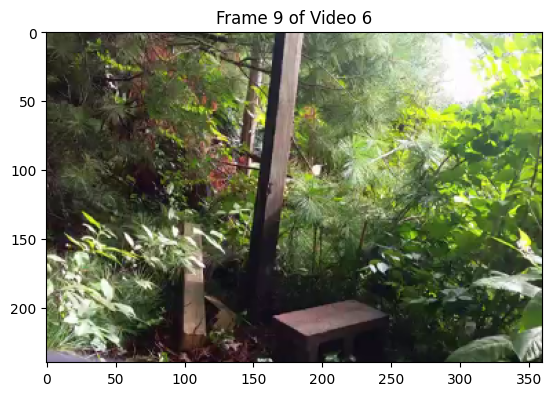

In [17]:
cnt=0
for element in VideoSet: 
	cnt+=1
	if cnt==6:
		print(element.shape) 
		plt.imshow(element[0,9, :,:,:])
		plt.title(f"Frame 9 of Video {cnt}")
		break

## 1: Super Simple TAE 

Flattened + fourier coded video patches:  (1, 990, 2495)


Text(0.5, 1.0, 'Row-wise Flattened Patches of Video 6')

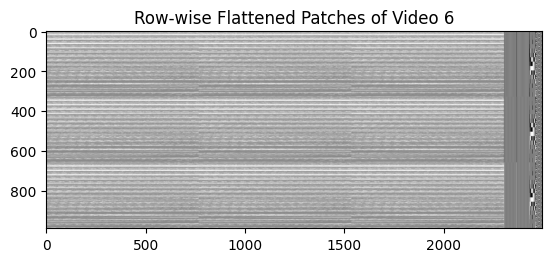

In [19]:
## Getting the patched + flattened + encoded tensor of shape [batch, tokens, token_dim]

flat_coded_1 = None 
cnt=0
vid_num=6

for element in FlatCodedPatchedSet:
	flat_coded_1 = element 
	cnt+=1 
	if cnt == vid_num:
		break

print("Flattened + fourier coded video patches: ",flat_coded_1.shape)
decoding_query = flat_coded_1[:,:,-191:]
decoding_query.shape
plt.imshow(flat_coded_1[0,:,:], cmap='gray')
plt.title(f"Row-wise Flattened Patches of Video {vid_num}")

<tf.Tensor: shape=(), dtype=float32, numpy=0.0004470998>

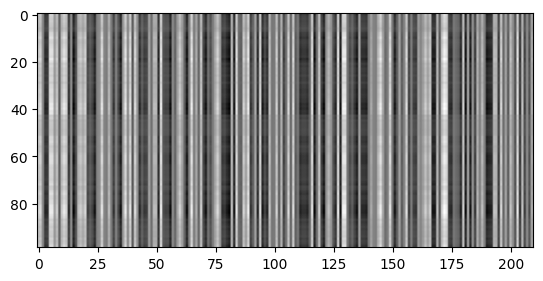

: 

In [136]:
## Self attention test 

self_attn_out, weights = tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=1, attention_axes=(1))(flat_coded_1, flat_coded_1, return_attention_scores=True)
plt.imshow(self_attn_out[0,1:100,1000:1210], cmap='gray')
tf.reduce_sum(self_attn_out[0,1,:] - self_attn_out[0,2,:])

TensorShape([1, 80, 990, 990])

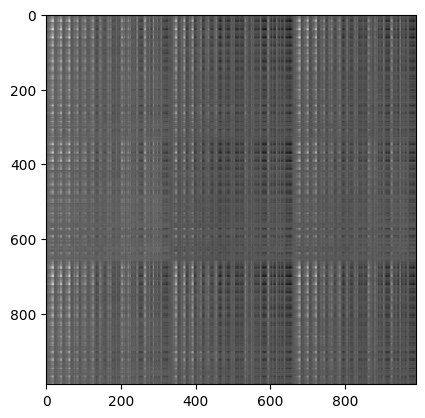

In [126]:
plt.imshow(weights[0,2,:,:], cmap='gray')
weights.shape

In [46]:
## Some constants governing the basic model 

# ENCODER: data -> latent 
M = flat_coded_1.shape[1] # data token dimension 
D = flat_coded_1.shape[2] # data channel dimension
print("M, D: ", (M, D))

N = 512					  # num latent token dimension 
C = 1024				  # latent channel dimension 
print("N, C: ", (N, C))

n_enc_heads = 16 
enc_key_dim = 64

n_latent_heads = 8
latent_key_dim = 128

n_dec_heads = 16
dec_key_dim = 64

num_latent_cycles = 1

M, D:  (990, 2495)
N, C:  (512, 1024)


In [109]:
def point_wise_feed_forward_network(
	d_model, # Input/output dimensionality.
	dff, # Inner-layer dimensionality.
	out_dim=None):

	if out_dim == None:
		return tf.keras.Sequential([
			tf.keras.layers.Dense(dff, activation='relu'),  # Shape `(batch_size, seq_len, dff)`.
			tf.keras.layers.Dense(d_model)  # Shape `(batch_size, seq_len, d_model)`.
		])
	else: 
		return tf.keras.Sequential([
			tf.keras.layers.Dense(dff, activation='relu'),  # Shape `(batch_size, seq_len, dff)`.
			tf.keras.layers.Dense(out_dim)  # Shape `(batch_size, seq_len, d_model)`.
		])

In [110]:
## Functional model: Inputs, shared layers
inputs = tf.keras.Input(shape=(M, D)) # for now, we keep these constant. 
								 	  # M can realistically change arbitrarily.
latent = tf.zeros([1, N, C]) # N rows (tokens), C channels (columns)


encoder_mha = tf.keras.layers.MultiHeadAttention(num_heads=n_enc_heads, key_dim=enc_key_dim, attention_axes=(1))
# encoder_c1 = tf.keras.layers.Conv1D(C*4, 1, activation="relu")
# encoder_c2 = tf.keras.layers.Conv1D(C, 1, activation="relu")
encoder_ffn = point_wise_feed_forward_network(C, C*4) # channel dim C, hidden dim C*
encoder_layernorm = tf.keras.layers.LayerNormalization()

latent_mha = tf.keras.layers.MultiHeadAttention(num_heads=n_latent_heads, key_dim=latent_key_dim)
latent_ffn = point_wise_feed_forward_network(C, C*4) # channel dim C, hidden dim C*
latent_layernorm = tf.keras.layers.LayerNormalization()

decoder_mha = tf.keras.layers.MultiHeadAttention(num_heads=n_dec_heads, key_dim=dec_key_dim)
decoder_ffn = point_wise_feed_forward_network(C, C*4, out_dim=D-191)
decoder_layernorm = tf.keras.layers.LayerNormalization()

In [113]:
## Functional model: 

# Encoder 
x_mh = encoder_mha(tf.ones([1, N, C]), inputs) # flat_coded_1[:,:,-191:]
print(x_mh.shape)
# x = encoder_c1(x)
# x = encoder_c2(x)
x_fn = encoder_ffn(x_mh)
print(x_fn.shape)
encoded = encoder_layernorm(x_fn)

# Latent -> latent 
x_c = latent_mha(encoded, encoded)
x_c = latent_layernorm(x_c + encoded) 
x_c2 = latent_ffn(x_c)
latent_ev = latent_layernorm(x_c2 + x_c) # evolved latent state

# Decoder -- decoding_query
x = decoder_mha(inputs[:,:,-191:], latent_ev)
outputs = decoder_ffn(x) 

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Minimal_TFA")

(1, 512, 1024)
(1, 512, 1024)


ValueError: Exception encountered when calling layer "layer_normalization_30" (type LayerNormalization).

Dimensions must be equal, but are 1024 and 191 for '{{node layer_normalization_30/mul_3}} = Mul[T=DT_FLOAT](layer_normalization_30/Reshape_1, layer_normalization_30/mul_3/ReadVariableOp)' with input shapes: [1,512,1024], [191].

Call arguments received by layer "layer_normalization_30" (type LayerNormalization):
  • inputs=tf.Tensor(shape=(1, 512, 1024), dtype=float32)

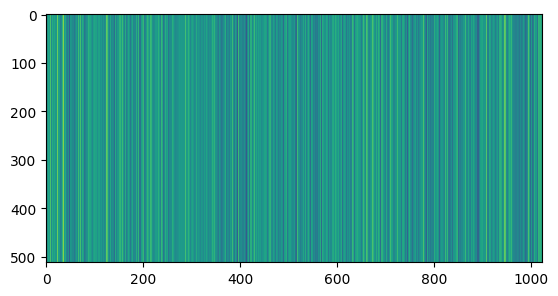

In [107]:
encoder = tf.keras.Model(inputs=inputs, outputs=x_mh, name="Encoder")
lat_lat = tf.keras.Model(inputs=encoded, outputs=latent_ev, name="Latent_to_Latent")
# decoder = tf.keras.Model(inputs=latent_ev, outputs=outputs, name="Decoder")

latent_1 = encoder(flat_coded_1)
plt.imshow(latent_1[0,:,:])

(1, 990, 2304)


Text(0.5, 1.0, 'Untrained Reconstruction')

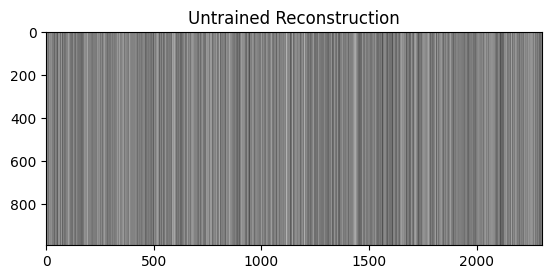

In [80]:
untrained_reconstruction=model(flat_coded_1)
print(untrained_reconstruction.shape)
plt.imshow(untrained_reconstruction[0,:,:], cmap='gray')
plt.title("Untrained Reconstruction")

Text(0.5, 1.0, 'Goal Reconstruction Target')

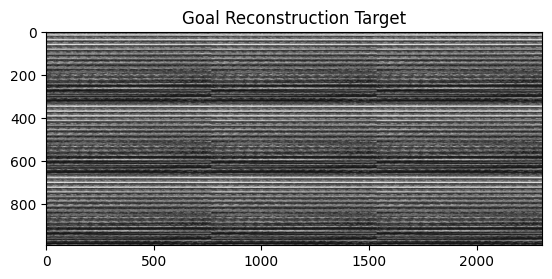

In [63]:
flat_goal = flat_coded_1[:,:,:-191]
plt.imshow(flat_goal[0,:,:], cmap='gray')
plt.title("Goal Reconstruction Target")

In [52]:
model.summary()

Model: "Minimal_TFA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 990, 2495)]  0           []                               
                                                                                                  
 multi_head_attention_3 (MultiH  (1, 512, 1024)      7211008     ['input_2[0][0]']                
 eadAttention)                                                                                    
                                                                                                  
 conv1d_2 (Conv1D)              (1, 512, 4096)       4198400     ['multi_head_attention_3[0][0]'] 
                                                                                                  
 conv1d_3 (Conv1D)              (1, 512, 1024)       4195328     ['conv1d_2[0][0]']     

In [29]:
tf.keras.utils.plot_model(model, "TAE_Sketch.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [53]:
## Compiling the model 
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001)
)

In [55]:
history = model.fit(flat_coded_1, flat_goal, batch_size=1, epochs=320, validation_split=0.0)

Epoch 1/320
1/1 [==============================] - 0s 32ms/step - loss: 0.1275
Epoch 2/320
1/1 [==============================] - 0s 20ms/step - loss: 0.1248
Epoch 3/320
1/1 [==============================] - 0s 20ms/step - loss: 0.1220
Epoch 4/320
1/1 [==============================] - 0s 20ms/step - loss: 0.1194
Epoch 5/320
1/1 [==============================] - 0s 21ms/step - loss: 0.1167
Epoch 6/320
1/1 [==============================] - 0s 20ms/step - loss: 0.1141
Epoch 7/320
1/1 [==============================] - 0s 20ms/step - loss: 0.1116
Epoch 8/320
1/1 [==============================] - 0s 21ms/step - loss: 0.1091
Epoch 9/320
1/1 [==============================] - 0s 21ms/step - loss: 0.1067
Epoch 10/320
1/1 [==============================] - 0s 19ms/step - loss: 0.1043
Epoch 11/320
1/1 [==============================] - 0s 17ms/step - loss: 0.1021
Epoch 12/320
1/1 [==============================] - 0s 19ms/step - loss: 0.0999
Epoch 13/320
1/1 [==============================]

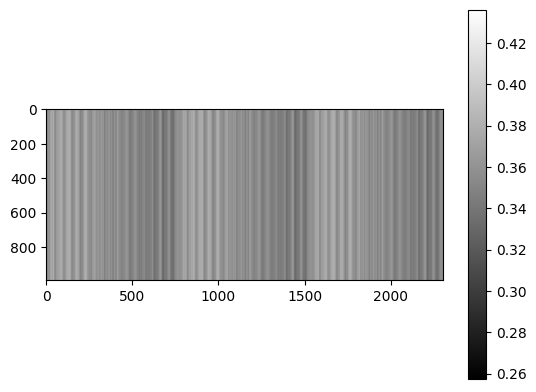

In [56]:
reconstruct = model(flat_coded_1)
plt.imshow(reconstruct[0,:,:], cmap='gray')
plt.colorbar()

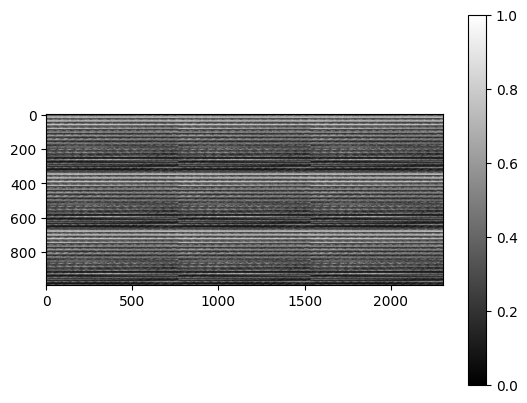

In [57]:
plt.imshow(flat_goal[0,:,:], cmap='gray')
plt.colorbar()

In [38]:
1/((990*2304)) * tf.norm(reconstruct-flat_goal)**2

<tf.Tensor: shape=(), dtype=float32, numpy=0.05698957>